# Machine Problem  
Nathaniel Cruel and Renzo Virtucio  
Department of Computer Science, University of the Philippines Diliman  
CS 180: Artificial Intelligence  
Professor Carlo Raquel  
June 15, 2021
***

## Introduction to the Problem
## Rationale
## Objective

## Methodology

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix

# Create dataframe
students_math = pd.read_csv('student/student-mat.csv', delimiter=';', header=0)
display(students_math)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2,2,services,services,...,5,5,4,4,5,4,11,9,9,9
391,MS,M,17,U,LE3,T,3,1,services,services,...,2,4,5,3,4,2,3,14,16,16
392,MS,M,21,R,GT3,T,1,1,other,other,...,5,5,3,3,3,3,3,10,8,7
393,MS,M,18,R,LE3,T,3,2,services,other,...,4,4,1,3,4,5,0,11,12,10


In [2]:
## PREPROCESSING ##
# Encoding binary attributes
students_math.school = students_math.school.map({"GP":0, "MS":1})
students_math.sex = students_math.sex.map({"F":0, "M":1})
students_math.address = students_math.address.map({"U":0, "R":1})
students_math.famsize = students_math.famsize.map({"LE3":0, "GT3":1})
students_math.Pstatus = students_math.Pstatus.map({"T":0, "A":1})
students_math.schoolsup = students_math.schoolsup.map({"yes":0, "no":1})
students_math.famsup = students_math.famsup.map({"yes":0, "no":1})
students_math.paid = students_math.paid.map({"yes":0, "no":1})
students_math.activities = students_math.activities.map({"yes":0, "no":1})
students_math.nursery = students_math.nursery.map({"yes":0, "no":1})
students_math.higher = students_math.higher.map({"yes":0, "no":1})
students_math.internet = students_math.internet.map({"yes":0, "no":1})
students_math.romantic = students_math.romantic.map({"yes":0, "no":1})

# Encoding nominal attributes
job_types = ["teacher", "health", "services", "at_home", "other"]
reason_types = ["home", "reputation", "course", "other"]
guardian_types = ["mother", "father", "other"]
Mjob_dum = pd.get_dummies(students_math['Mjob'], prefix='Mjob')
Fjob_dum = pd.get_dummies(students_math['Fjob'], prefix='Fjob')
reason_dum = pd.get_dummies(students_math['reason'], prefix='reason')
guardian_dum = pd.get_dummies(students_math['guardian'], prefix='guardian')

students_math = pd.concat([students_math, Mjob_dum, Fjob_dum, reason_dum, guardian_dum], axis=1)
students_math.drop(['Mjob', 'Fjob', 'reason', 'guardian'], axis=1, inplace=True)
students_math

# Add a column describing if G3 (final grade) is high or low
# High = 12-20 (60% of 20 and above)
# Low = 0-11 (below 60% of 20)
students_math["quality"] = (students_math.G3 >= 12).map({True: 1, False: 0})
display(students_math)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,...,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,quality
0,0,0,18,0,1,1,4,4,2,2,...,0,1,1,0,0,0,0,1,0,0
1,0,0,17,0,1,0,1,1,1,2,...,0,0,1,0,0,0,1,0,0,0
2,0,0,15,0,0,0,1,1,1,2,...,0,0,0,0,1,0,0,1,0,0
3,0,0,15,0,1,0,4,2,1,3,...,1,0,0,1,0,0,0,1,0,1
4,0,0,16,0,1,0,3,3,1,2,...,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,1,1,20,0,0,1,2,2,1,2,...,1,0,1,0,0,0,0,0,1,0
391,1,1,17,0,0,0,3,1,2,1,...,1,0,1,0,0,0,0,1,0,1
392,1,1,21,1,1,0,1,1,1,1,...,0,0,1,0,0,0,0,0,1,0
393,1,1,18,1,0,0,3,2,3,1,...,0,0,1,0,0,0,0,1,0,0


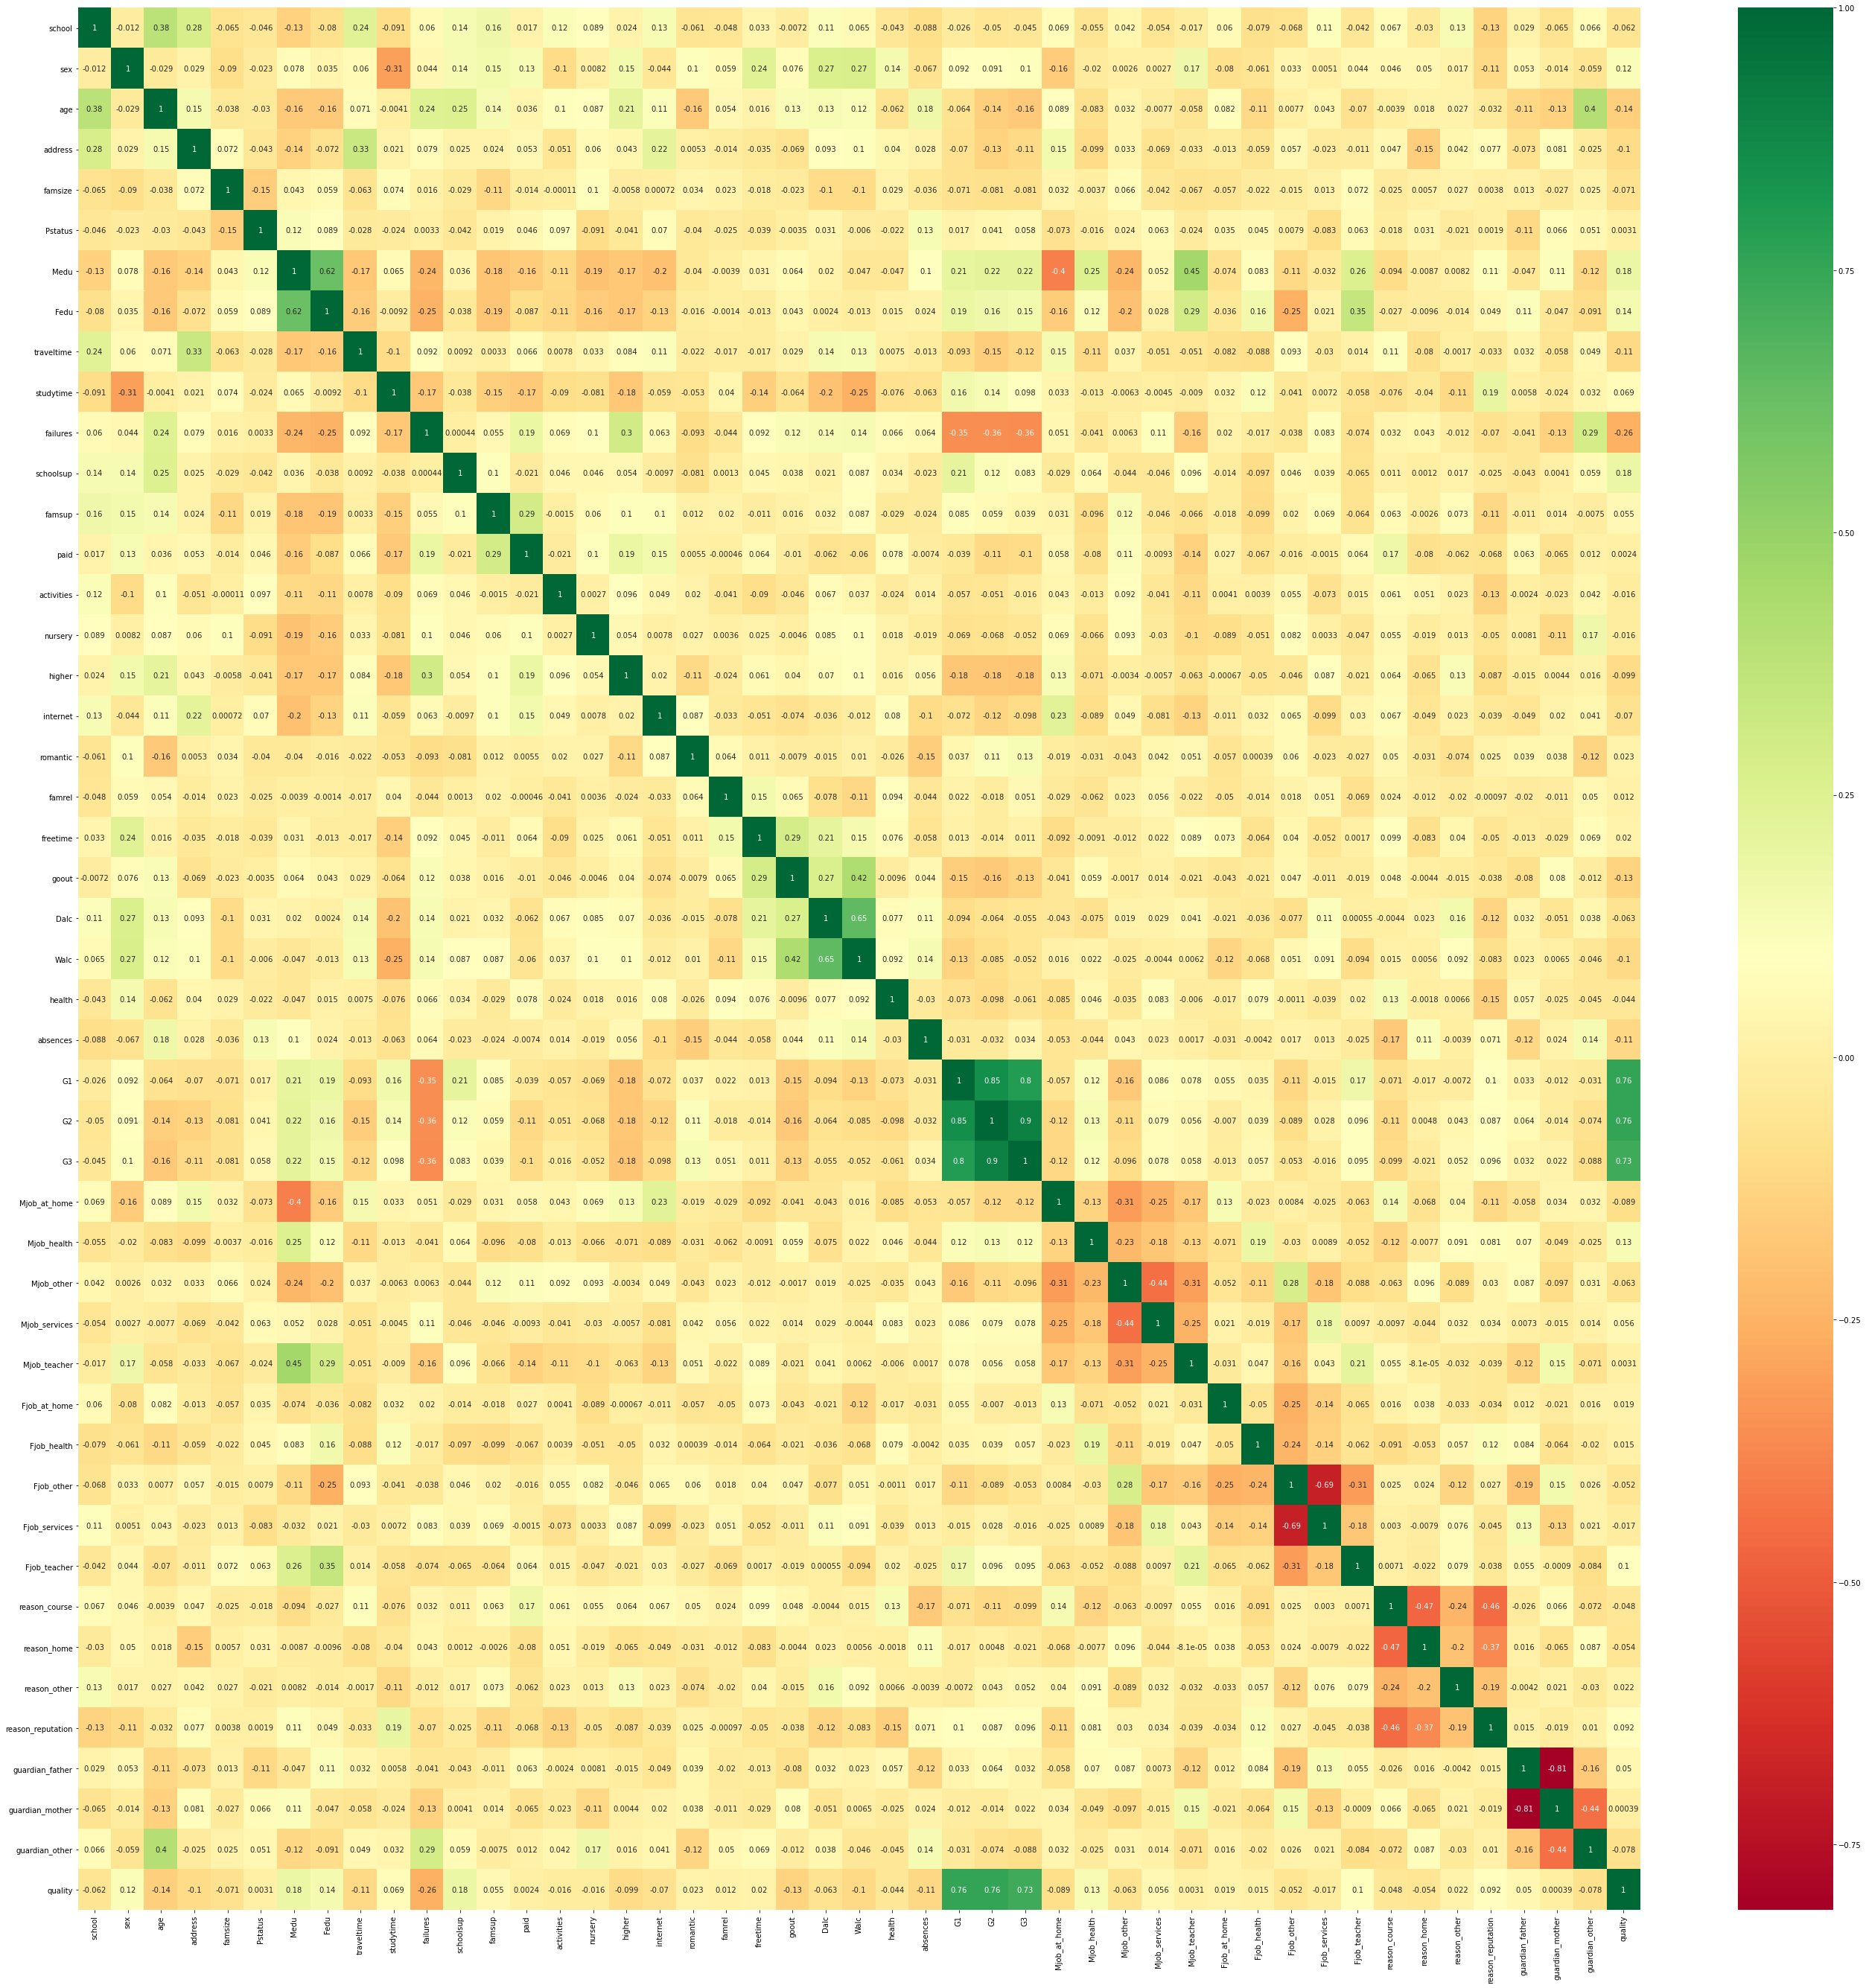

In [3]:
# Determine correlation per two variables
corrmat = students_math.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(47,47))

# Plot heat map
g=sns.heatmap(students_math[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [4]:
# Define X and y for testing and training
y = students_math['quality']
X = students_math.drop('quality', axis=1)
print(X.shape, y.shape)

(395, 46) (395,)


In [5]:
# Compute for the Variance Inflation Factor of each variable to identify
# multicollinearity
def calculate_vif(data):
    vif_df = pd.DataFrame(columns = ['Var', 'Vif'])
    x_var_names = data.columns
    for i in range(0, x_var_names.shape[0]):
        y = data[x_var_names[i]]
        x = data[x_var_names.drop([x_var_names[i]])]
        r_squared = sm.OLS(y,x).fit().rsquared
        vif = round(1/(1-r_squared),2)
        vif_df.loc[i] = [x_var_names[i], vif]
    return vif_df.sort_values(by = 'Vif', axis = 0, ascending=False, inplace=False)

# Observe that some variables have a very large VIF, signalling multicollinearity
calculate_vif(X)

<ipython-input-5-1884e569ce5d>:10: RuntimeWarning: divide by zero encountered in double_scalars
  vif = round(1/(1-r_squared),2)


,Var,Vif
45,guardian_other,inf
36,Fjob_other,inf
29,Mjob_at_home,inf
30,Mjob_health,inf
31,Mjob_other,inf
32,Mjob_services,inf
33,Mjob_teacher,inf
34,Fjob_at_home,inf
35,Fjob_health,inf
37,Fjob_services,inf


Text(0, 0.5, 'cumulative explained variance')

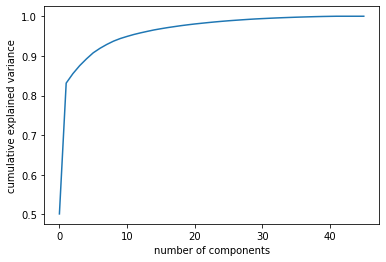

In [6]:
# To address multicollinearity, we utilize Principal Component Analysis.
# Determine the optimal number of components based on the cumulative
# explained variance.
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [7]:
# Standardize the data
X = StandardScaler().fit_transform(X)
# PCA Projection
pca = PCA(n_components=46)  
principalComponents = pca.fit_transform(X)
X = pd.DataFrame(data = principalComponents)

# Display new dataframe
display(X)
# Observe that the Variance Inflation Factor are low and uniform (1.0)
calculate_vif(X)  


,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
0,0.927484,-0.840491,-2.230791,0.075635,3.241159,0.549802,0.336031,2.951931,0.766498,2.640543,...,-0.629415,1.111634,0.493013,0.852893,-0.667527,0.112138,5.689384e-15,-3.846209e-16,4.674427e-16,6.393659e-16
1,2.708141,-2.326974,0.251784,1.008527,1.196890,-1.855163,-0.070419,-0.267774,-0.559993,-1.376930,...,0.537594,-0.114353,0.629944,0.156558,-0.616857,-0.159982,2.605772e-15,1.516984e-15,1.724478e-15,-4.271606e-16
2,2.414809,-0.959040,-0.520183,-0.228715,0.409586,0.717919,-0.975530,-1.663085,3.417475,0.538045,...,-1.735033,0.300944,-0.241612,-0.158789,0.017092,-0.329626,-5.478516e-15,-9.577274e-16,-3.080727e-16,7.511572e-16
3,-3.282898,-0.988667,-0.070482,1.341861,-0.196774,0.974245,-0.550632,-0.324009,1.607897,-1.800499,...,0.067553,-0.561934,0.543495,0.222135,0.204102,-0.395516,3.255907e-15,-9.201250e-16,-2.985468e-16,1.448567e-16
4,0.198983,-1.799809,-0.360612,1.003382,-1.255741,-2.316066,0.907100,1.368883,1.174061,-0.945655,...,-0.292084,-0.015238,-0.183753,0.474554,-0.769300,0.190027,3.788939e-16,2.682205e-18,-3.668556e-16,-1.336765e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,3.201173,4.101285,1.643863,1.555614,-0.953602,2.178888,-0.941096,-0.169443,-1.521325,1.272303,...,-0.749564,-0.958640,-0.397761,-0.189805,0.004063,0.014332,8.983211e-16,1.402366e-16,-1.041097e-17,-2.112778e-16
391,0.479339,3.741654,2.846360,-1.600863,0.845027,0.663094,-0.812253,-1.232295,0.843554,-0.301623,...,-0.423714,-0.528937,0.804757,0.752659,0.075159,0.156146,-2.768663e-16,-1.398297e-16,2.032742e-18,-9.157441e-18
392,5.930164,1.365891,3.157931,-0.544373,-1.242927,0.273892,0.720304,1.320383,-3.158136,0.563211,...,-0.006548,-0.068982,0.174999,-0.442750,0.212938,-0.018117,-4.137967e-17,-2.641219e-17,-1.009969e-16,-9.632774e-18
393,2.041445,2.322284,2.075475,-2.653776,1.300047,0.018235,0.876963,-0.272024,-0.399184,0.585460,...,0.037915,0.343653,-0.229205,0.690488,0.064653,0.463338,-3.652177e-16,-1.576230e-16,9.018555e-17,-9.523685e-17


,Var,Vif
0,0.0,1.0
34,34.0,1.0
25,25.0,1.0
26,26.0,1.0
27,27.0,1.0
28,28.0,1.0
29,29.0,1.0
30,30.0,1.0
31,31.0,1.0
32,32.0,1.0


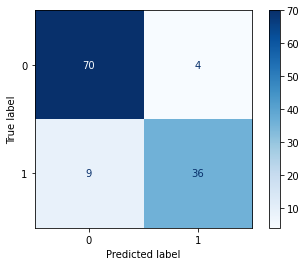

              precision    recall  f1-score   support

           0       0.89      0.95      0.92        74
           1       0.90      0.80      0.85        45

    accuracy                           0.89       119
   macro avg       0.89      0.87      0.88       119
weighted avg       0.89      0.89      0.89       119



In [8]:
# Split the data for testing and training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Fitting a support vector machine
model = SVC()
model.fit(X_train, y_train)

# Compute model predictions
model_predictions = model.predict(X_test)
# Plot confusion matrix
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)  
plt.show() 
# Print classification report
print(classification_report(y_test, model_predictions))

In [9]:
# Use GridSearchCV to optimize the parameters of SVC
# Defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ('linear', 'rbf', 'poly', 'sigmoid')} 

# Create grid object
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3, n_jobs=-1)
  
# Fitting the model for grid search
grid.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 348 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    4.1s finished


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ('linear', 'rbf', 'poly', 'sigmoid')},
             verbose=3)

In [10]:
# Print best parameter after tuning
print(grid.best_params_)
 
# Print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 10, 'gamma': 1, 'kernel': 'linear'}
SVC(C=10, gamma=1, kernel='linear')


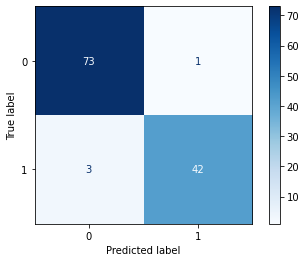

              precision    recall  f1-score   support

           0       0.96      0.99      0.97        74
           1       0.98      0.93      0.95        45

    accuracy                           0.97       119
   macro avg       0.97      0.96      0.96       119
weighted avg       0.97      0.97      0.97       119



In [11]:
# Compute grid predictions
grid_predictions = grid.predict(X_test)

# Plot confusion matrix
plot_confusion_matrix(grid, X_test, y_test, cmap=plt.cm.Blues)  
plt.show() 
# Print classification report
print(classification_report(y_test, grid_predictions))

## Data and Analysis

## Conclusion

## Individual Contributions